In [9]:
from __future__ import annotations
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import keras
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv("../data/Credit.csv")

cat_columns = list(data.select_dtypes(include=["object"]).columns)
le = LabelEncoder()
for col in cat_columns:
    data[col] = le.fit_transform(data[col])

X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:, :-1],
    data.iloc[:, -1],
    test_size=0.3,
    random_state=0
)

num_columns = list(set(data.columns) - set(cat_columns))
scaler = MinMaxScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [11]:
class Individual:
    def __init__(self, generation: int=0) -> None:
        self.generation = generation
        self.gene = [0 if np.random.random() < 0.5 else 1 for _ in range(12)]
        self.eval = 0
    
    def _evaluate(self, X_train, X_test, y_train, y_test) -> None:
        self.model = keras.Sequential()
        self.model.add(keras.layers.Input(shape=(20, )))
        for _ in range(int("".join(map(str, self.gene[0:3])), 2) + 1):
            self.model.add(keras.layers.Dense(int("".join(map(str, self.gene[3:7])), 2) + 1, activation="relu"))
        for _ in range(int("".join(map(str, self.gene[7:9])), 2) + 1):
            self.model.add(keras.layers.Dense(int("".join(map(str, self.gene[9:12])), 2) + 1, activation="relu"))
        self.model.add(keras.layers.Dense(1, activation="sigmoid"))

        self.model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        self.model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, verbose=False)

        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=False)

        self.loss = loss
        self.eval = accuracy

    def crossover(self, other_individual: Individual) -> list[Individual]:
        cut = round(np.random.rand() * len(self.gene))
        child1 = other_individual.gene[0:cut] + self.gene[cut::]
        child2 = self.gene[0:cut] + other_individual.gene[cut::]

        children = [Individual(self.generation + 1), Individual(self.generation + 1)]
        
        children[0].gene = child1
        children[1].gene = child2
        
        return children

    def mutation(self, mutation_rate: float) -> Individual:
        for i in range(len(self.gene)):
            if np.random.random() < mutation_rate:
                if self.gene[i]:
                    self.gene[i] = 0
                else:
                    self.gene[i] = 1
        return self
    
    def __repr__(self):
        return f"""Generation: {self.generation}
Gene: {self.gene}
{int("".join(map(str, self.gene[0:3])), 2) + 1} camadas com {int("".join(map(str, self.gene[3:7])), 2) + 1} neurons
{int("".join(map(str, self.gene[7:9])), 2) + 1} camadas com {int("".join(map(str, self.gene[9:12])), 2) + 1} neurons
"""

In [12]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = 0
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self, individual: Individual) -> None:
        if individual.eval > self.best_solution.eval:
            self.best_solution = individual
    
    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, sum_eval:float) -> int:
        parent = -1
        value = np.random.rand() * sum_eval
        sum = 0
        i = 0
        while i < len(self.population) and sum < value:
            sum += self.population[i].eval
            parent += 1
            i += 1
        return parent

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for individual in self.population:
            individual._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
        
        self.sort_population()

        self.best_solution = self.population[0]
        self.solution_list.append(self.best_solution.eval)

        self.visualize_generation()

        for i in range(generations):
            print(f"Generation {i + 1}")
            eval_sum = self.sum_eval()
            new_population = []

            for _ in range(0, self.population_size, 2):
                parent1 = self.select_parent(eval_sum)
                parent2 = self.select_parent(eval_sum)

                children = self.population[parent1].crossover(self.population[parent2])

                new_population.append(children[0].mutation(mutation_rate))   
                new_population.append(children[1].mutation(mutation_rate))

            self.population = list(new_population)

            for individual in self.population:
                individual._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
            
            pareto = []
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    pareto.append(individual)

            self.pareto.extend(pareto)
            

            self.sort_population()
            self.visualize_generation()

            self.solution_list.append(self.population[0].eval)

            self.best_individual(self.population[0])
        
        self.pareto_frontier = []
        for individual in self.pareto:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.pareto)

            if frontier:
                self.pareto_frontier.append(individual)

        print(f"Best Solution -> G:{self.best_solution.generation} -> ",
              f"Eval: {round(self.best_solution.eval, 3)}",
              f" Gene: {self.best_solution.gene}")
        
        return self.best_solution

ga = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)

In [13]:
result = ga.solve(generations=10)

Generation 0
G:0 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Generation 1
G:1 ->  Eval: 0.73  Gene: [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]
Generation 2
G:2 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Generation 3
G:3 ->  Eval: 0.74  Gene: [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
Generation 4
G:4 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Generation 5
G:5 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
Generation 6
G:6 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Generation 7
G:7 ->  Eval: 0.71  Gene: [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
Generation 8
G:8 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Generation 9
G:9 ->  Eval: 0.71  Gene: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
Generation 10
G:10 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0]
Best Solution -> G:3 ->  Eval: 0.737  Gene: [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [14]:
result

Generation: 3
Gene: [0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]
1 camadas com 14 neurons
2 camadas com 8 neurons

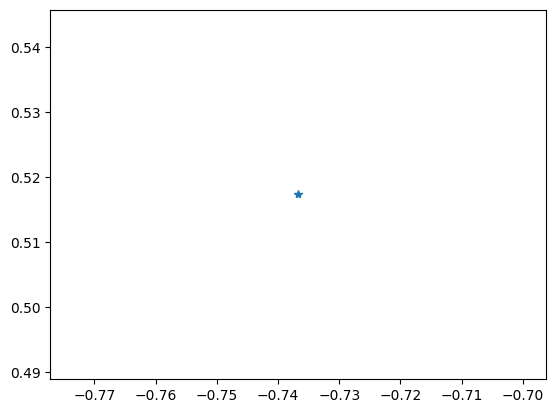

In [15]:
loss = []
acc = []
for individual in ga.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [21]:
ga2 = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)
result2 = ga2.solve(generations=10)
result2

Generation 0
G:0 ->  Eval: 0.71  Gene: [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0]
Generation 1
G:1 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]
Generation 2
G:2 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Generation 3
G:3 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Generation 4
G:4 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Generation 5
G:5 ->  Eval: 0.71  Gene: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Generation 6
G:6 ->  Eval: 0.71  Gene: [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
Generation 7
G:7 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Generation 8
G:8 ->  Eval: 0.73  Gene: [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
Generation 9
G:9 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Generation 10
G:10 ->  Eval: 0.71  Gene: [1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0]
Best Solution -> G:8 ->  Eval: 0.727  Gene: [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]


Generation: 8
Gene: [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
6 camadas com 7 neurons
1 camadas com 4 neurons

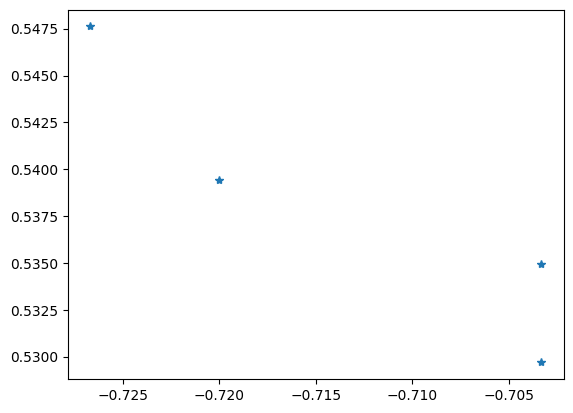

In [22]:
loss = []
acc = []
for individual in ga2.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [28]:
ga3 = GeneticAlgorithm(6, X_train, X_test, y_train, y_test)
result3 = ga3.solve(generations=10)
result3

Generation 0
G:0 ->  Eval: 0.71  Gene: [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]
Generation 1
G:1 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Generation 2
G:2 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Generation 3
G:3 ->  Eval: 0.72  Gene: [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Generation 4
G:4 ->  Eval: 0.71  Gene: [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Generation 5
G:5 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]
Generation 6
G:6 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]
Generation 7
G:7 ->  Eval: 0.71  Gene: [1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Generation 8
G:8 ->  Eval: 0.72  Gene: [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Generation 9
G:9 ->  Eval: 0.71  Gene: [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]
Generation 10
G:10 ->  Eval: 0.71  Gene: [1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
Best Solution -> G:2 ->  Eval: 0.72  Gene: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]


Generation: 2
Gene: [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
2 camadas com 9 neurons
4 camadas com 6 neurons

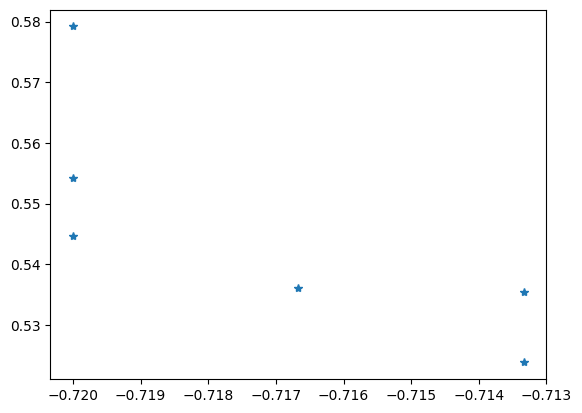

In [29]:
loss = []
acc = []
for individual in ga3.pareto_frontier:
    loss.append(individual.loss)
    acc.append(-individual.eval)
plt.plot(acc, loss, marker="*", linestyle="None")

In [ ]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, X_train, X_test, y_train, y_test) -> None:
        self.population_size = population_size
        self.population = []
        self.generation = 0
        self.eval_sum = 0
        self.best_solution = 0
        self.solution_list = []
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.pareto = []

    def init_population(self) -> None:
        for _ in range(self.population_size):
            self.population.append(Individual())
        self.best_solution = self.population[0]

    def sort_population(self) -> None:
        self.population = sorted(self.population, key=lambda individual: individual.eval, reverse=True)

    def best_individual(self, individual: Individual) -> None:
        if individual.eval > self.best_solution.eval:
            self.best_solution = individual
    
    def sum_eval(self) -> float:
        sum = 0
        for individual in self.population:
            sum += individual.eval
        return sum

    def select_parent(self, sum_eval:float) -> int:
        parent = -1
        value = np.random.rand() * sum_eval
        sum = 0
        i = 0
        while i < len(self.population) and sum < value:
            sum += self.population[i].eval
            parent += 1
            i += 1
        return parent

    def visualize_generation(self) -> None:
        best = self.population[0]
        print(f"G:{self.population[0].generation} -> ",
              f"Eval: {round(best.eval, 2)}",
              f" Gene: {best.gene}")

    def solve(self, mutation_rate=0.05, generations=0) -> list[int]:
        self.init_population()

        print("Generation 0")

        for individual in self.population:
            individual._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
        
        self.sort_population()

        self.best_solution = self.population[0]
        self.solution_list.append(self.best_solution.eval)

        self.visualize_generation()

        for i in range(generations):
            print(f"Generation {i + 1}")
            eval_sum = self.sum_eval()
            new_population = []

            for _ in range(0, self.population_size, 2):
                parent1 = self.select_parent(eval_sum)
                parent2 = self.select_parent(eval_sum)

                children = self.population[parent1].crossover(self.population[parent2])

                new_population.append(children[0].mutation(mutation_rate))   
                new_population.append(children[1].mutation(mutation_rate))

            self.population = list(new_population)

            for individual in self.population:
                individual._evaluate(self.X_train, self.X_test, self.y_train, self.y_test)
            
            pareto = []
            for individual in self.population:
                frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.population)

                if frontier:
                    pareto.append(individual)

            self.pareto.extend(pareto)
            

            self.sort_population()
            self.visualize_generation()

            self.solution_list.append(self.population[0].eval)

            self.best_individual(self.population[0])
        
        self.pareto_frontier = []
        for individual in self.pareto:
            frontier = not any((individual.loss > other_individual.loss and individual.eval < other_individual.eval) for other_individual in self.pareto)

            if frontier:
                self.pareto_frontier.append(individual)

        print(f"Best Solution -> G:{self.best_solution.generation} -> ",
              f"Eval: {round(self.best_solution.eval, 3)}",
              f" Gene: {self.best_solution.gene}")
        
        return self.best_solution